# Time series analysis | Vladimir Bogdanov

## Average monthly russian wages prediction, based on Russian Federal State Statistics Service data (http://gks.ru)

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product


Populating the interactive namespace from numpy and matplotlib


/Users/VB/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


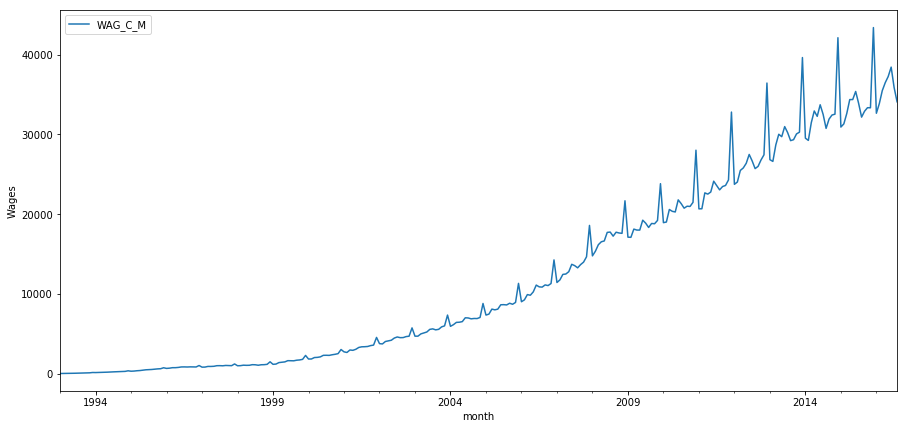

In [2]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
data.plot()
plt.ylabel('Wages')
pylab.show()

In [3]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Checking for stationarity and STL-decomposition: 

Dickey — Fuller test: p=0.991850


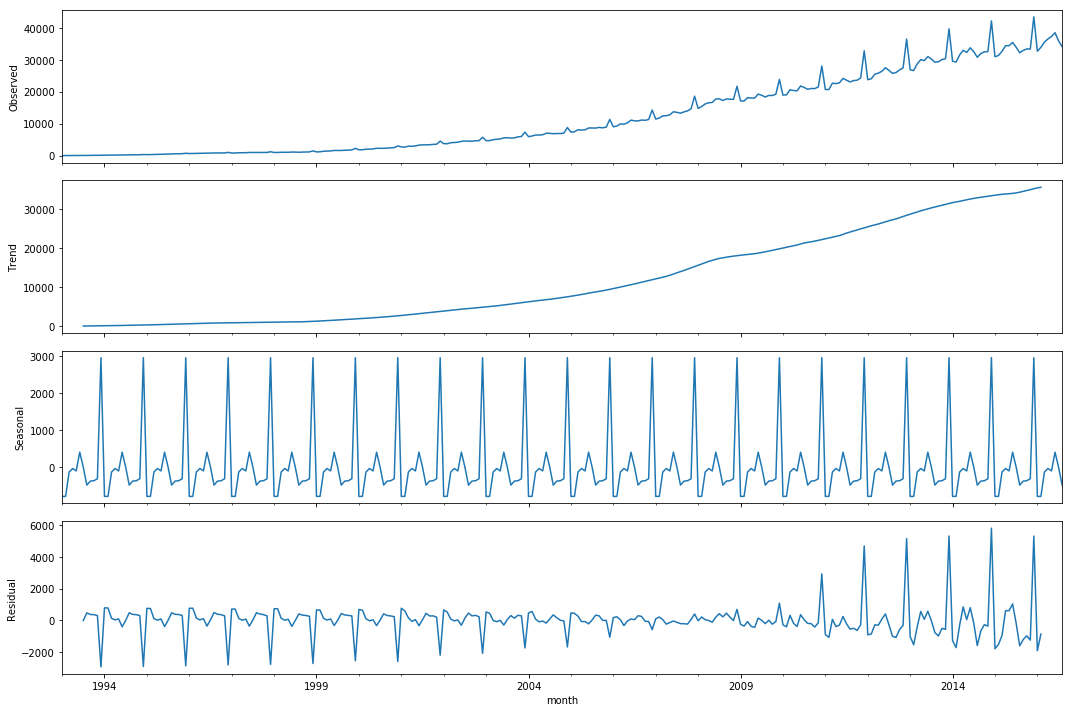

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Dickey — Fuller test parameter: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

### Variance stabilization

#### Using Box-Cox transformation for variance stabilization:  

Optimal Box-Cox transformation parameter: 0.263202
Dickey — Fuller test parameter: p=0.696899


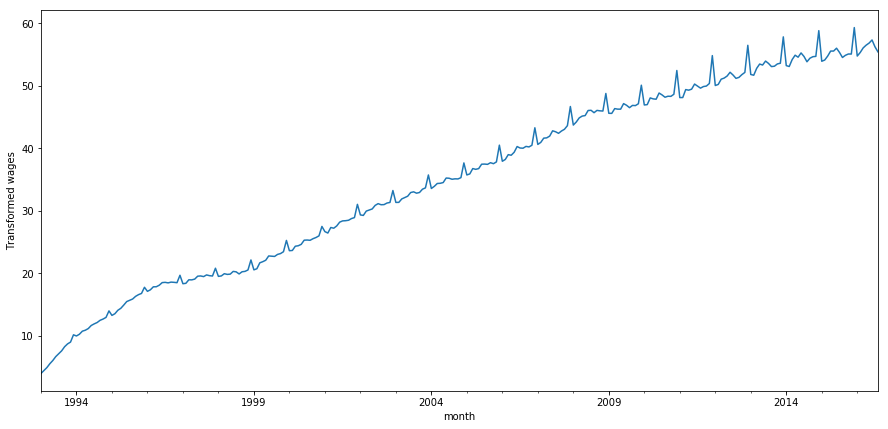

In [5]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed wages')
print("Optimal Box-Cox transformation parameter: %f" % lmbda)
print("Dickey — Fuller test parameter: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

### Stationarity

#### Based on Dickey - Fuller test stationarity should be rejected, but from the visual analysis we see there is some trend presents in the data. So I'm going to try seasonal differentiation: let's make STL-decomposition on differentiated series and check for stationarity:

Dickey — Fuller test parameter: p=0.014697


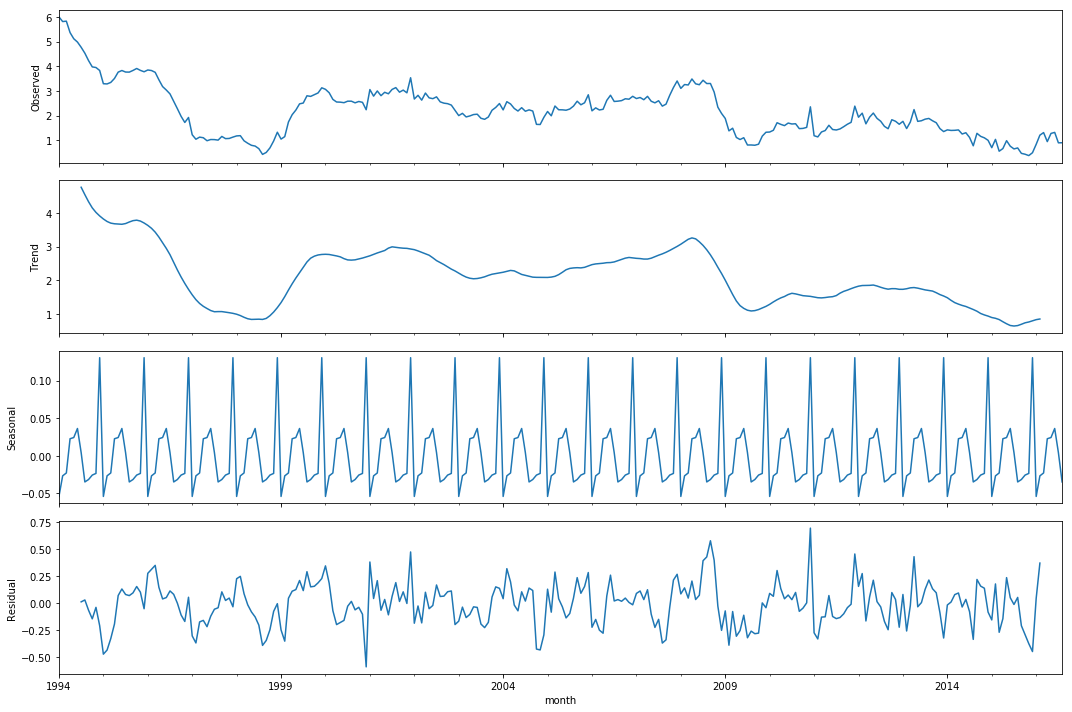

In [7]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print("Dickey — Fuller test parameter: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

#### Based on Dickey - Fuller test stationarity should be rejected, but from the visual analysis it could be seen that some trend is still there, so I'm going to add usual differentiation as well: 

Dickey — Fuller test parameter: p=0.000000


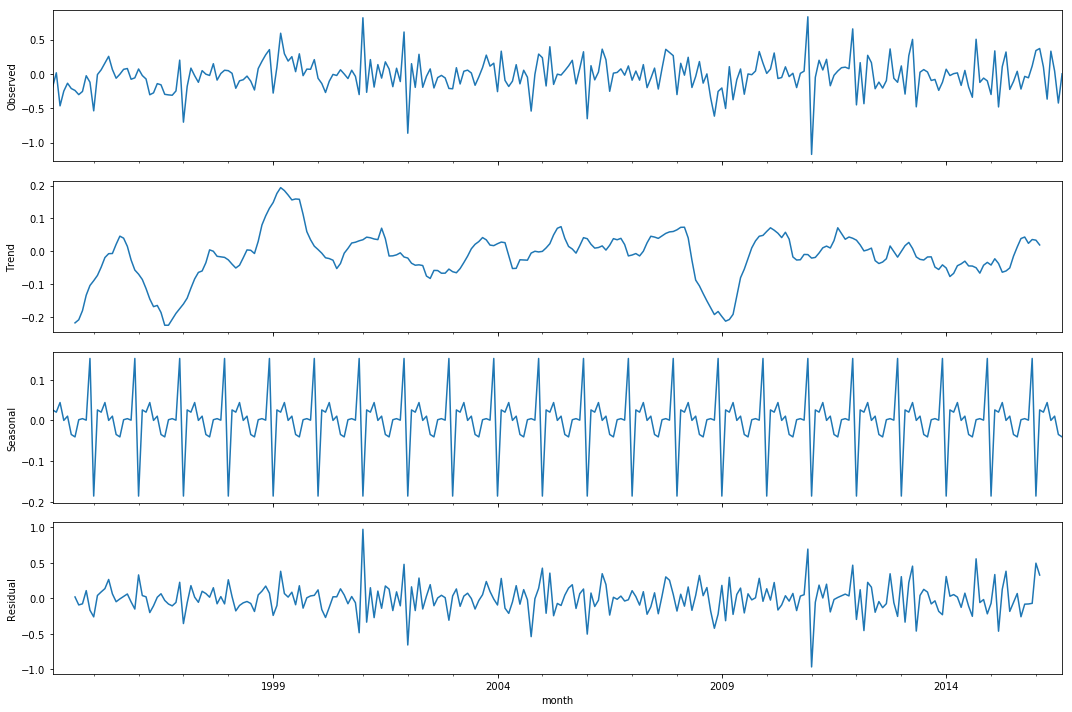

In [8]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()   
print("Dickey — Fuller test parameter: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

#### As for now, we could reject non-stationarity hypothesis both from statistical and visual analysis, there is no trend anymore.

## Choosing an appropriate model

#### Let's have a look at ACF & PACF of the series:

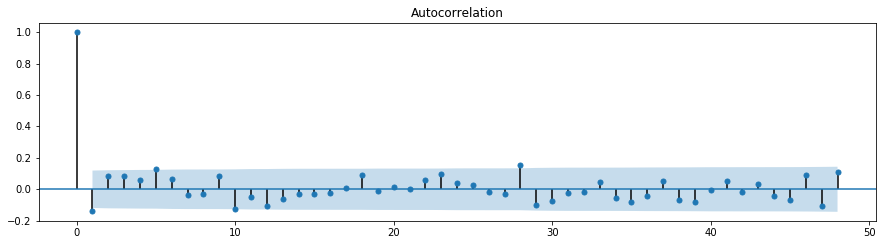

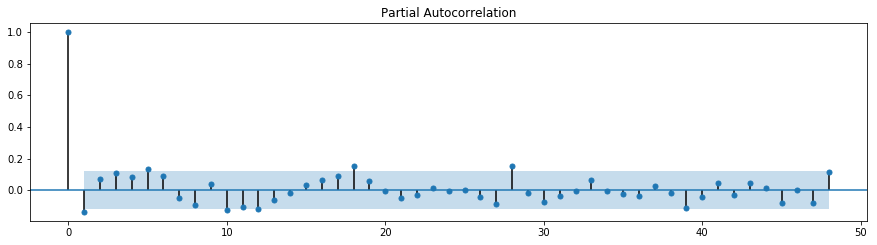

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

#### Inital parameters: Q=0, q=1, P=1, p=5

In [10]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1


In [11]:
parameters = product(ps, qs, Ps)
parameters_list = list(parameters)
len(parameters_list)

24

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except is needed, because on some sets of parameters the model is not trained
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, 0, 12)).fit(disp=-1)
    #output parameters on which the model is not trained and move on to the next set
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0))
('wrong parameters:', (2, 1, 0))
('wrong parameters:', (2, 1, 1))
CPU times: user 7.44 s, sys: 277 ms, total: 7.72 s
Wall time: 7.58 s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters       aic
20  (5, 1, 1) -5.260134
12  (3, 1, 1) -4.995860
18  (5, 0, 1) -4.545934
16  (4, 1, 1) -3.975974
17  (5, 0, 0) -2.104961


#### The best model:

In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  10.630
Date:                            Sun, 13 May 2018   AIC                             -5.260
Time:                                    18:08:44   BIC                             23.932
Sample:                                01-01-1993   HQIC                             6.443
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2016      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      0.105   

#### Model's residuals:

Student's t-test: p=0.296137
Dickey — Fuller test parameter: p=0.000000


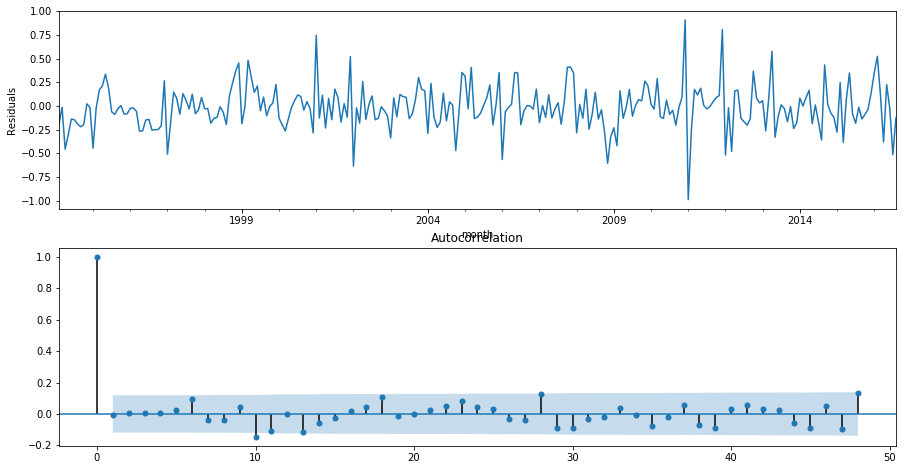

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's t-test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey — Fuller test parameter: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

### Residuals unbiased (confirmed by Student's test), stationary (confirmed both visually and via Dicker-Fuller), not autocorrelated (confirmed by a correlogram).


In [59]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

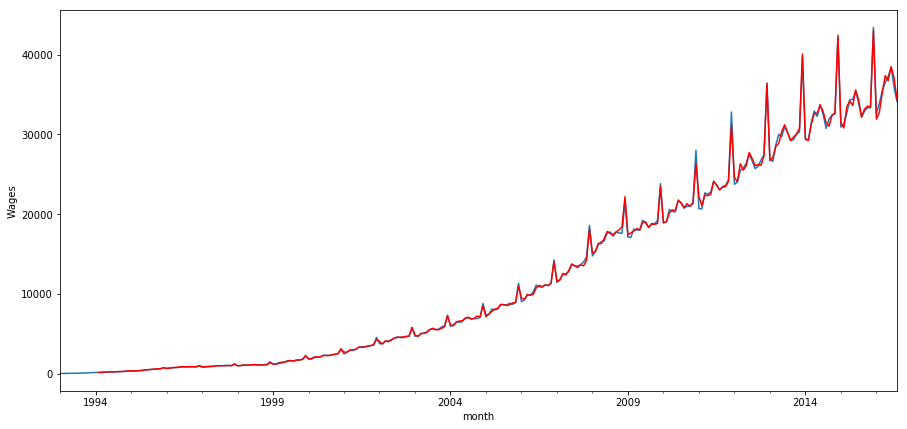

In [68]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Wages')
pylab.show()

### Using the model for future periods wages prediction:

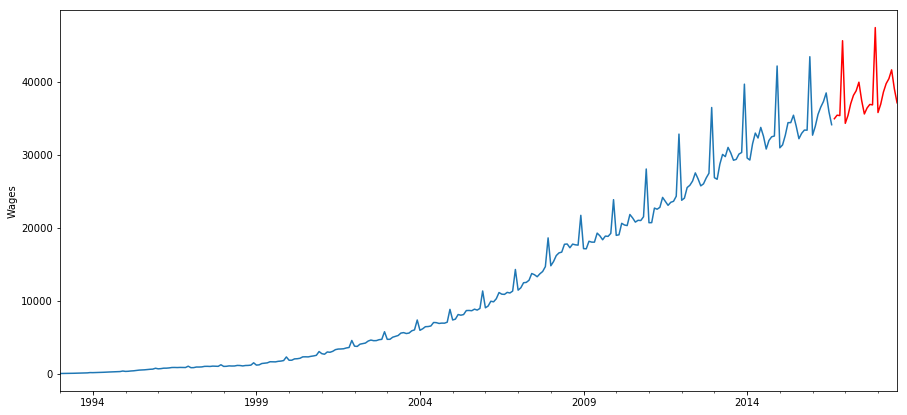

In [69]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)
best_model.predict
plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Wages')
pylab.show()

### Since I've made this analysis at the 2018, I could easily check that model has come really close to the actual data, which is already available on http://gks.ru